# Online Analysis of the UNSWN Dataset 

## About 

This notebook evaluates several different online learning algorithms on the [UNSW-NB15 Dataset](https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/) ([link](https://ieeexplore.ieee.org/abstract/document/7348942) to paper). The UNSW-NB15 dataset has nine types of attacks, namely, Fuzzers, Analysis, Backdoors, DoS, Exploits, Generic, Reconnaissance, Shellcode and Worms. The Argus, Bro-IDS tools are used and twelve algorithms are developed to generate totally 49 features with the class label. This notebook looks at the problem of detecting binary attacks (i.e., we do not consider classifying a specific attack). The original features in the UNSW-NB15 dataset were reduced based on some preliminary work and identification of features that could not easily be processed by the classifiers and exploratory data analysis. 

[Scikit Multiflow](https://scikit-multiflow.github.io/) is required to run the code and will be installed when the notebook is run. Furthermore, the data must be downloaded from UNSW-NB15's website and the current notebook is accessing the data through a Google Drive. 


## Contributors 
* [Gregory Ditzler](http://gditzler.github.io/) [[gregory.ditzler@gmail.com](mailto:gregory.ditzler@gmail.com)]

## Citation 
* Gregory Ditzler and Srishti Gupta, "Beyond Signature-Based Intrusion Detection with Online Learning," in preparation for *IEEE Access*, 2020. 

# Install Dependencies and Load Modules

In [ ]:
!pip install -U scikit-multiflow

     |████████████████████████████████| 1.1MB 2.8MB/s 


In [ ]:
import os 
import numpy as np 
import scipy as sp
import pandas as pd 
import pickle as pkl 
from scipy.stats import poisson

import matplotlib.pylab as plt
plt.style.use('ggplot')

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from skmultiflow.data import DataStream
from skmultiflow.trees import HoeffdingTreeClassifier
from skmultiflow.meta import OzaBaggingClassifier 
from skmultiflow.meta import OzaBaggingADWINClassifier 
from skmultiflow.meta import LeveragingBaggingClassifier
from skmultiflow.evaluation import EvaluatePrequential, EvaluateHoldout


from google.colab import drive, files

drive.mount('/content/drive')

Mounted at /content/drive


# Define Functions and Constants 

In [ ]:
def standardize_df(df): 
  """
  Standardize a dataframe

  df = standardize_df(df)
  """
  for key in df.keys(): 
    if key != 'target': 
      df[key] = (df[key].values - df[key].values.mean())/df[key].values.std()
  return df

def standardize_df_off_tr(df_tr, df_te): 
  """
  Standardize dataframes from a training and testing frame, where the means
  and standard deviations that are calculated from the training dataset. 

  df_tr, df_te = standardize_df_off_tr(df_tr, df_te)
  """
  for key in df_tr.keys(): 
    if key != 'target': 
      # scale the testing data w/ the training means/stds
      df_te[key] = (df_te[key].values - df_tr[key].values.mean())/df_tr[key].values.std()
      # scale the training data 
      df_tr[key] = (df_tr[key].values - df_tr[key].values.mean())/df_tr[key].values.std()
  return df_tr, df_te

def calc_metrics(y, yhat):
  """
  Calculate the accuracy, f1-score and kappa statistics 

  acc, f1, kappa = calc_metrics(y, yhat)
  """
  tp = 1.*len(np.where((y == 0) & (yhat == 0))[0])
  tn = 1.*len(np.where((y == 1) & (yhat == 1))[0])
  fp = 1.*len(np.where((y == 1) & (yhat == 0))[0])
  fn = 1.*len(np.where((y == 0) & (yhat == 1))[0])
  n = tp+tn+fp+fn
  acc = (tp+tn)/(tp+tn+fp+fn)
  f1 = 2*tp/(2*tp+fp+fn)
  
  po = 1.*acc
  py, pn = ((tp+fp)/n)*((tp+fn)/n), ((fn+tn)/n)*((fp+tn)/n)
  pe = py+pn
  kappa = (po-pe)/(1-pe)
  return acc, f1, kappa 

def jaccard(a, b): 
  """
  Compute the jaccard index between two feature sets 
  """
  return 1.*len(set(a).intersection(set(b)))/len(set(a).union(set(b)))

def kuncheva(a, b, K): 
  """
  Compute the kuncheva index between two sets 
  """
  k = len(a)
  a, b = set(sort_mite[:k]), set(sort_mitr[:k])
  r = 1.*len(a.intersection(b))
  return (r*K-k**2)/(k*(K-k))

In [ ]:
# number of data samples used to pre-train the model 
pretrain_size = 2000
# prequential batch sizes 
batch_size = 1000
# classification metrics to compute in prequential online learning 
metrics = ['accuracy', 'f1', 'kappa', 'running_time', 'model_size']
# location of the data in the Google Drive 
data_path = '/content/drive/My Drive/Data/UNSWNB15/'
# location of the code in Google Drive 
code_path = '/content/drive/My Drive/Colab Notebooks/Projects/TIS-IEEE-2020/'
# output path for the result files and figures 
output_path = code_path+'outputs/'
# maximum numbers to sample from the stream. we will not process 1M  
max_samples = 1000000

output_files = [
                'output_ht_m',
                'output_bag_m',
                'output_bagwin_m',
                'output_leverage_m'
                ]
clfrs = [
         HoeffdingTreeClassifier(), 
         OzaBaggingClassifier(base_estimator=HoeffdingTreeClassifier()),
         OzaBaggingADWINClassifier(base_estimator=HoeffdingTreeClassifier()),
         LeveragingBaggingClassifier(base_estimator=HoeffdingTreeClassifier())
         ]
N = len(clfrs)

drop_cols = ['id', 'proto', 'service', 'state', 'attack_cat', 'is_sm_ips_ports']


# Run the Online Algorithms - Prequential



In [ ]:
# read in the csv files saved in the google drive 
df_tr, df_te = pd.read_csv(data_path + 'UNSW_NB15_training-set.csv'), pd.read_csv(data_path + 'UNSW_NB15_testing-set.csv')

# 1) randomly shuffle rows; 2) rename label column; 3) drop not useful columns 
df_tr = df_tr.sample(frac=1).reset_index(drop=True).rename(columns={"label": "target"}).drop(drop_cols, axis = 1)
df_te = df_te.sample(frac=1).reset_index(drop=True).rename(columns={"label": "target"}).drop(drop_cols, axis = 1)

# standardize the training and testing data stream. use the mean/std of the 
# training data to standarized the testing data (i.e., only use information 
# available at training time). 
df_tr, df_te = standardize_df_off_tr(df_tr, df_te)

N1 = len(df_tr)

# concat the training and testing data into a stream 
df = pd.concat([df_tr, df_te])
stream = DataStream(df)

In [ ]:
mdls = []
evals = []

for n in range(N): 
  print('Running... ' + output_files[n])
  mdl = clfrs[n]   # get the classifier 
  # configure the prequential datastream evaluator. results are saved to the 
  # google drive. 
  eval = EvaluatePrequential(show_plot=False, 
                             pretrain_size=pretrain_size, 
                             batch_size=batch_size, 
                             metrics=metrics, 
                             max_samples=max_samples,
                             output_file=output_path + output_files[n] + '.csv')
  # process the datastream then save off the models and evaluation 
  mdl = eval.evaluate(stream=stream, model=mdl)
  mdls.append(mdl[0])
  evals.append(eval)
  print(' ')

# write the output to a pickle file 
data = {'mdls': mdls, 'evals': evals}
pkl.dump(data, open(output_path + 'prequential_models_evaluators.pkl', 'wb'))

Running... output_ht_m
Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 2000 sample(s).
Evaluating...
 #################### [100%] [116.26s]
Processed samples: 258000
Mean performance:
M0 - Accuracy     : 0.9221
M0 - Kappa        : 0.8273
M0 - F1 score: 0.9408
M0 - Training time (s)  : 79.97
M0 - Testing time  (s)  : 25.68
M0 - Total time    (s)  : 105.65
M0 - Size (kB)          : 3733.9375
 
Running... output_bag_m
Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 2000 sample(s).
Evaluating...
 #################### [100%] [1339.87s]
Processed samples: 258000
Mean performance:
M0 - Accuracy     : 0.9291
M0 - Kappa        : 0.8427
M0 - F1 score: 0.9462
M0 - Training time (s)  : 943.51
M0 - Testing time  (s)  : 278.42
M0 - Total time    (s)  : 1221.93
M0 - Size (kB)          : 40707.3477
 
Running... output_bagwin_m
Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 2000 sample(s).
Evaluating...
 #################### [100%] [1538.75s]
Processed samp

In [ ]:
# the results from the prequential experiements need to be loaded from the drive 
# since they are not in the environment
df_ht = pd.read_csv(output_path + 'output_ht_m.csv', comment='#')
df_bag = pd.read_csv(output_path + 'output_bag_m.csv', comment='#')
df_bagwin = pd.read_csv(output_path + 'output_bagwin_m.csv', comment='#')
df_leverage = pd.read_csv(output_path + 'output_leverage_m.csv', comment='#')

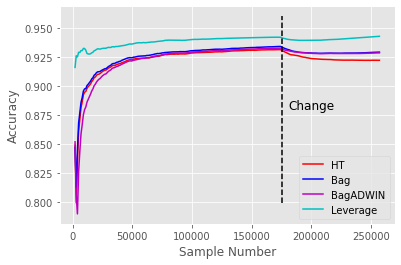

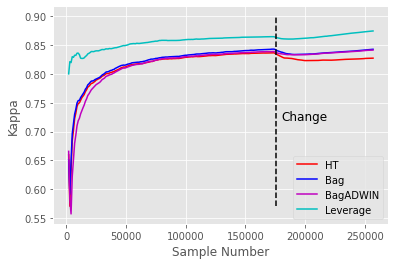

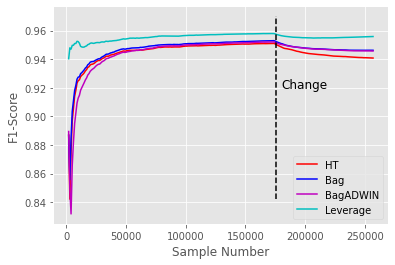

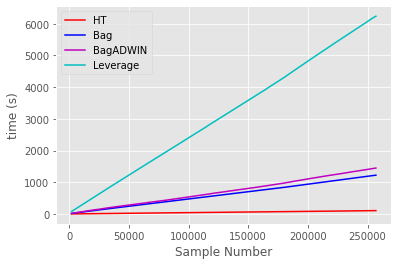

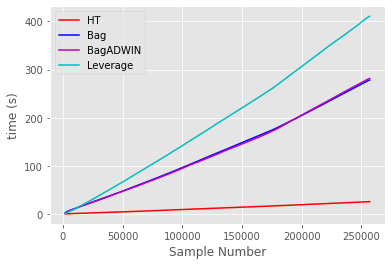

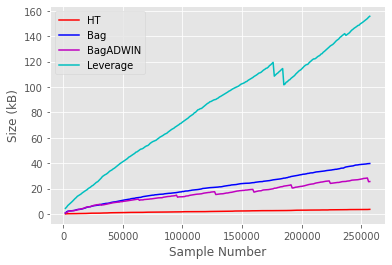

In [ ]:
# plot the accuracies 
plt.figure()
plt.plot(df_ht['id'], df_ht['mean_acc_[M0]'], color='r', label='HT')
plt.plot(df_bag['id'], df_bag['mean_acc_[M0]'], color='b', label='Bag')
plt.plot(df_bagwin['id'], df_bagwin['mean_acc_[M0]'], color='m', label='BagADWIN')
plt.plot(df_leverage['id'], df_leverage['mean_acc_[M0]'], color='c', label='Leverage')
plt.plot([N1,N1], [np.min(df_ht['mean_acc_[M0]']), 0.96], color='k', linestyle='--')
plt.text(N1+5000, .88, 'Change', fontsize=12)
plt.legend()
plt.xlabel('Sample Number')
plt.ylabel('Accuracy')
plt.savefig(output_path + 'online_accuracy_m.pdf')

# plot the kappa statistics 
plt.figure()
plt.plot(df_ht['id'], df_ht['mean_kappa_[M0]'], color='r', label='HT')
plt.plot(df_bag['id'], df_bag['mean_kappa_[M0]'], color='b', label='Bag')
plt.plot(df_bagwin['id'], df_bagwin['mean_kappa_[M0]'], color='m', label='BagADWIN')
plt.plot(df_leverage['id'], df_leverage['mean_kappa_[M0]'], color='c', label='Leverage')
plt.plot([N1,N1], [np.min(df_ht['mean_kappa_[M0]']), 0.9], color='k', linestyle='--')
plt.text(N1+5000, .72, 'Change', fontsize=12)
plt.legend()
plt.xlabel('Sample Number')
plt.ylabel('Kappa')
plt.savefig(output_path + 'online_kappa_m.pdf')

# plot the f1-scores 
plt.figure()
plt.plot(df_ht['id'], df_ht['mean_f1_[M0]'], color='r', label='HT')
plt.plot(df_bag['id'], df_bag['mean_f1_[M0]'], color='b', label='Bag')
plt.plot(df_bagwin['id'], df_bagwin['mean_f1_[M0]'], color='m', label='BagADWIN')
plt.plot(df_leverage['id'], df_leverage['mean_f1_[M0]'], color='c', label='Leverage')
plt.plot([N1,N1], [np.min(df_ht['mean_f1_[M0]']), 0.97], color='k', linestyle='--')
plt.text(N1+5000, .92, 'Change', fontsize=12)
plt.legend()
plt.xlabel('Sample Number')
plt.ylabel('F1-Score')
plt.savefig(output_path + 'online_f1_m.pdf')



# plot the total_running_time_ 
plt.figure()
plt.plot(df_ht['id'], df_ht['total_running_time_[M0]'], color='r', label='HT')
plt.plot(df_bag['id'], df_bag['total_running_time_[M0]'], color='b', label='Bag')
plt.plot(df_bagwin['id'], df_bagwin['total_running_time_[M0]'], color='m', label='BagADWIN')
plt.plot(df_leverage['id'], df_leverage['total_running_time_[M0]'], color='c', label='Leverage')
plt.legend()
plt.xlabel('Sample Number')
plt.ylabel('time (s)')
plt.savefig(output_path + 'online_time_m.pdf')

# plot the testing_time_ 
plt.figure()
plt.plot(df_ht['id'], df_ht['testing_time_[M0]'], color='r', label='HT')
plt.plot(df_bag['id'], df_bag['testing_time_[M0]'], color='b', label='Bag')
plt.plot(df_bagwin['id'], df_bagwin['testing_time_[M0]'], color='m', label='BagADWIN')
plt.plot(df_leverage['id'], df_leverage['testing_time_[M0]'], color='c', label='Leverage')
plt.legend()
plt.xlabel('Sample Number')
plt.ylabel('time (s)')
plt.savefig(output_path + 'online_test_time_m.pdf')


# plot the model_size_ 
plt.figure()
plt.plot(df_ht['id'], df_ht['model_size_[M0]']/1024, color='r', label='HT')
plt.plot(df_bag['id'], df_bag['model_size_[M0]']/1024, color='b', label='Bag')
plt.plot(df_bagwin['id'], df_bagwin['model_size_[M0]']/1024, color='m', label='BagADWIN')
plt.plot(df_leverage['id'], df_leverage['model_size_[M0]']/1024, color='c', label='Leverage')
plt.legend()
plt.xlabel('Sample Number')
plt.ylabel('Size (kB)')
plt.savefig(output_path + 'online_size_m.pdf')


In [ ]:
# print out the latex tables 
print('\\bf Metric & \\bf HT & \\bf Bagging & \\bf BagADWIN & \\bf Leverage \\\\')
print('\\hline\\hline')
print('Accuracy & ', 
      str(100*df_ht['mean_acc_[M0]'].values[-1]) + ' & ',
      str(100*df_bag['mean_acc_[M0]'].values[-1]) + ' & ',
      str(100*df_bagwin['mean_acc_[M0]'].values[-1]) + ' & ',
      str(100*df_leverage['mean_acc_[M0]'].values[-1]) + ' \\\\ '
      )
print('$\kappa$ & ', 
      str(100*df_ht['mean_kappa_[M0]'].values[-1]) + ' & ',
      str(100*df_bag['mean_kappa_[M0]'].values[-1]) + ' & ',
      str(100*df_bagwin['mean_kappa_[M0]'].values[-1]) + ' & ',
      str(100*df_leverage['mean_kappa_[M0]'].values[-1]) + ' \\\\ '
      )
print('F1-Score & ', 
      str(100*df_ht['mean_f1_[M0]'].values[-1]) + ' & ',
      str(100*df_bag['mean_f1_[M0]'].values[-1]) + ' & ',
      str(100*df_bagwin['mean_f1_[M0]'].values[-1]) + ' & ',
      str(100*df_leverage['mean_f1_[M0]'].values[-1]) + ' \\\\ '
      )

\bf Metric & \bf HT & \bf Bagging & \bf BagADWIN & \bf Leverage \\
\hline\hline
Accuracy &  92.2108 &  92.914 &  92.8495 &  94.2728 \\ 
$\kappa$ &  82.73370000000001 &  84.27319999999999 &  84.135 &  87.4491 \\ 
F1-Score &  94.07610000000001 &  94.6191 &  94.568 &  95.58139999999999 \\ 


# Evaluate Online Models - Holdout

In [ ]:
# read in the csv files saved in the google drive 
df_tr, df_te = pd.read_csv(data_path + 'UNSW_NB15_training-set.csv'), pd.read_csv(data_path + 'UNSW_NB15_testing-set.csv')

# 1) randomly shuffle rows; 2) rename label column; 3) drop not useful columns 
df_tr = df_tr.sample(frac=1).reset_index(drop=True).drop(drop_cols, axis = 1).rename(columns={"label": "target"})
df_te = df_te.sample(frac=1).reset_index(drop=True).drop(drop_cols, axis = 1).rename(columns={"label": "target"})

# standardize the training and testing data stream. use the mean/std of the 
# training data to standarized the testing data (i.e., only use information 
# available at training time). 
df_tr, df_te = standardize_df_off_tr(df_tr, df_te)

# set the data stream for learning. we are only going to use the training stream 
# to build the model; however, unlike the previous experiement we do not care 
# about the output result stream. rather we want the hold out performance 
stream = DataStream(df_tr)

X_train = df_tr.values[:,:-1]
y_train = df_tr['target'].values
X_hold = df_te.values[:,:-1]
y_hold = df_te['target'].values

# reset the base classifiers for the learning model and setup the base clfr 
# names for the latex tables 
clfrs = [
         HoeffdingTreeClassifier(), 
         OzaBaggingClassifier(base_estimator=HoeffdingTreeClassifier()),
         OzaBaggingADWINClassifier(base_estimator=HoeffdingTreeClassifier()),
         LeveragingBaggingClassifier(base_estimator=HoeffdingTreeClassifier())
         ]
clfrs_names = ['HT', 'Bag', 'BagADWIN', 'Leverage']

N = len(clfrs)
accs, f1s, kappas = [], [], []

for n in range(N): 
  print(clfrs_names[n])

  # learn the model on the training data stream that is defined by the training 
  # data. this is specified by the original authors 
  mdl = clfrs[n]
  eval = EvaluatePrequential(show_plot=False, 
                             pretrain_size=pretrain_size, 
                             batch_size=batch_size, 
                             metrics=metrics, 
                             max_samples=max_samples,
                             output_file=output_path + 'tmp.csv')
  mdl = eval.evaluate(stream=stream, model=mdl)

  # get the predictions on the hold out dataset then calculate the accuracy, 
  # f1-score and kappa statistics. 
  y_hat = mdl[0].predict(X_hold)
  acc, f1, kappa = calc_metrics(y_hold, y_hat)
  accs.append(acc)
  f1s.append(f1)
  kappas.append(kappa)
  print(' ')

# remove the temporary data file that was used to save the prequential results 
# of the online models. all the algorithms write the same tmp.csv file. 
os.remove(output_path + 'tmp.csv')

# write the classification statistics to a python file  
data = {'accs': accs, 'f1s': f1s, 'kappas': kappas, 'clfr_names': clfrs_names}
pkl.dump(data, open(output_path + 'holdout_classifcation_statistics.pkl', 'wb'))

HT
Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 2000 sample(s).
Evaluating...
 #################### [100%] [83.56s]
Processed samples: 176000
Mean performance:
M0 - Accuracy     : 0.9160
M0 - Kappa        : 0.7987
M0 - F1 score: 0.9404
M0 - Training time (s)  : 59.27
M0 - Testing time  (s)  : 18.01
M0 - Total time    (s)  : 77.28
M0 - Size (kB)          : 3178.7578
 
Bag
Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 2000 sample(s).
Evaluating...
 #################### [100%] [948.22s]
Processed samples: 176000
Mean performance:
M0 - Accuracy     : 0.9322
M0 - Kappa        : 0.8383
M0 - F1 score: 0.9517
M0 - Training time (s)  : 698.18
M0 - Testing time  (s)  : 184.08
M0 - Total time    (s)  : 882.26
M0 - Size (kB)          : 28364.5586
 
BagADWIN
Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 2000 sample(s).
Evaluating...
 #################### [100%] [1053.39s]
Processed samples: 176000
Mean performance:
M0 - Accuracy     : 0.9321
M0 - 

In [ ]:
static_clfr_name = [
                    'CART (static)',
                    'Bagging (static)'
                    ]
static_clfr = [DecisionTreeClassifier(), BaggingClassifier()]
accs_static, f1s_static, kappas_static = [], [], []

for n in range(len(static_clfr)):
  print(static_clfr_name[n])
  y_hat = static_clfr[n].fit(X_train, y_train).predict(X_hold)
  acc, f1, kappa = calc_metrics(y_hold, y_hat)
  accs_static.append(acc)
  f1s_static.append(f1)
  kappas_static.append(kappa)


CART (static)
Bagging (static)


In [ ]:
# print out the latex tables  
' & '.join(clfrs_names) + '\\\\'
for n in range(N): 
  print(clfrs_names[n] + ' & ' + str(100*accs[n])+ ' & ' + str(100*f1s[n])+ ' & ' + str(100*kappas[n]) + '\\\\')

for n in range(len(static_clfr)): 
  print(static_clfr_name[n] + ' & ' + str(100*accs_static[n])+ ' & ' + str(100*f1s_static[n])+ ' & ' + str(100*kappas_static[n]) + '\\\\')


HT & 84.00257494048486 & 79.64013541296316 & 66.90897219671726\\
Bag & 84.95603167662634 & 80.94461538461537 & 68.905647918331\\
BagADWIN & 83.13899820240003 & 77.87447005195881 & 64.9489505403212\\
Leverage & 86.90302676966428 & 83.4872360300761 & 72.95057370815134\\
CART (static) & 86.10625273283777 & 82.88471609186804 & 71.41629348190031\\
Bagging (static) & 87.57348297138415 & 84.6554180727409 & 74.42448886471898\\


# Exploratory Data Analysis

## Principal Components Analysis 

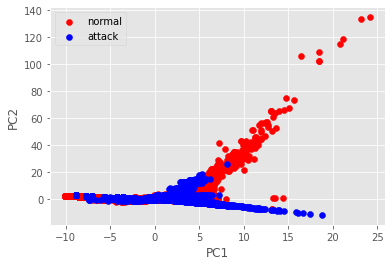

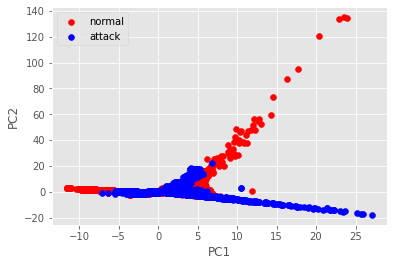

In [ ]:
# read in the csv files saved in the google drive 
df_tr, df_te = pd.read_csv(data_path + 'UNSW_NB15_training-set.csv'), pd.read_csv(data_path + 'UNSW_NB15_testing-set.csv')

# 1) randomly shuffle rows; 2) rename label column; 3) drop not useful columns 
df_tr, df_te = df_tr.sample(frac=1).reset_index(drop=True), df_te.sample(frac=1).reset_index(drop=True)
df_tr_drop, df_te_drop = df_tr.drop(drop_cols, axis = 1), df_te.drop(drop_cols, axis = 1)

# separate the data from the labels for the training and testing data 
Xtr, Xte = df_tr_drop.values[:,:-1], df_te_drop.values[:,:-1]
ytr, yte = df_tr_drop['label'].values, df_te_drop['label'].values

# standardize the data based on the transform found from the training data 
scaler = preprocessing.StandardScaler().fit(Xtr)
Xtr, Xte = scaler.transform(Xtr), scaler.transform(Xte)

# calculate the PCA projections and find projections 
pct = PCA(n_components=2).fit(Xtr)
Xtr_pca, Xte_pca = pct.transform(Xtr), pct.transform(Xte)

# plot out the PCA projections on the training and testing data 
plt.figure()
plt.scatter(Xtr_pca[ytr==1,0], Xtr_pca[ytr==1,1], color='r', label='normal')
plt.scatter(Xtr_pca[ytr==0,0], Xtr_pca[ytr==0,1], color='b', label='attack')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.savefig(output_path + 'pca_tr.pdf')

plt.figure()
plt.scatter(Xte_pca[yte==1,0], Xte_pca[yte==1,1], color='r', label='normal')
plt.scatter(Xte_pca[yte==0,0], Xte_pca[yte==0,1], color='b', label='attack')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.savefig(output_path + 'pca_te.pdf')


## Mutual Information Ranks and Stability 

*   List item
*   List item




egin{enumerate}
  \item dsport: Destination port number
  \item dur: Record total duration
  \item proto: Transaction protocol
  \item sbytes: Source to destination transaction bytes 
  \item Stime: record start time
  \item state: Indicates to the state and its dependent protocol, e.g. ACC, CLO, CON, ECO, ECR, FIN, INT, MAS, PAR, REQ, RST, TST, TXD, URH, URN, and (-) (if not used state)
  \item dbytes: Destination to source transaction bytes
  \item srcip: Source IP address
  \item dmeansz: Mean of the ?ow packet size transmitted by the dst 
  \item trans_depth: Represents the pipelined depth into the connection of http request/response transaction
\end{enumerate}


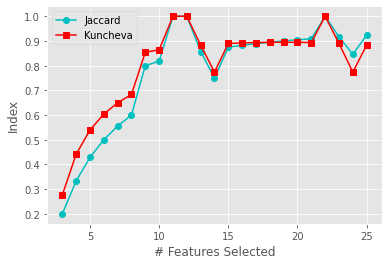

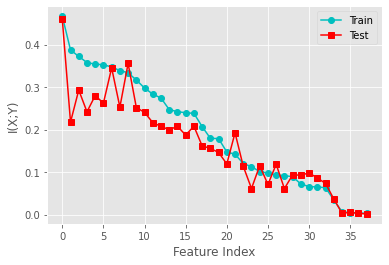

In [ ]:
n_avg = 10

# read in the csv files saved in the google drive 
df_tr, df_te = pd.read_csv(data_path + 'UNSW_NB15_training-set.csv'), pd.read_csv(data_path + 'UNSW_NB15_testing-set.csv')
feature_names = pd.read_csv(data_path + 'NUSW-NB15_features.csv')['Name'].values
feature_descr = pd.read_csv(data_path + 'NUSW-NB15_features.csv')['Description'].values

# 1) randomly shuffle rows; 2) rename label column; 3) drop not useful columns 
df_tr = df_tr.sample(frac=1).reset_index(drop=True).drop(drop_cols, axis = 1).rename(columns={"label": "target"})
df_te = df_te.sample(frac=1).reset_index(drop=True).drop(drop_cols, axis = 1).rename(columns={"label": "target"})

# standardize the training and testing data stream. use the mean/std of the 
# training data to standarized the testing data (i.e., only use information 
# available at training time). 
df_tr, df_te = standardize_df_off_tr(df_tr, df_te)

Xtr, Xte, ytr, yte = df_tr.values[:,:-1], df_te.values[:,:-1], df_tr.values[:,-1], df_te.values[:,-1]


mitr, mite = mutual_info_classif(Xtr, ytr), mutual_info_classif(Xte, yte)
sort_mitr, sort_mite = np.argsort(mitr)[::-1], np.argsort(mite)[::-1]

k_max = 25
K = Xtr.shape[1]

jacs, kunc, x = [], [], []
for k in range(3, k_max+1):
  x.append(k)
  jacs.append(jaccard(sort_mitr[:k], sort_mite[:k]))
  kunc.append(kuncheva(sort_mitr[:k], sort_mite[:k], K))

plt.figure()
plt.plot(x, jacs, color='c', marker='o', label='Jaccard')
plt.plot(x, kunc, color='r', marker='s', label='Kuncheva')
plt.xlabel('# Features Selected')
plt.ylabel('Index')
plt.legend()
plt.savefig(output_path + 'feature_stabilities.pdf')


plt.figure()
plt.plot(mitr[sort_mitr], color='c', marker='o', label='Train')
plt.plot(mite[sort_mitr], color='r', marker='s', label='Test')
plt.xlabel('Feature Index')
plt.ylabel('I(X;Y)')
plt.legend()
plt.savefig(output_path + 'feature_ranks.pdf')

# print out the top 10 features in a latex list
print('\begin{enumerate}')
for i in sort_mitr[:10]:
  print('  \item ' + feature_names[i] + ': ' + feature_descr[i]) 
print('\end{enumerate}')     

# Misc Plots 

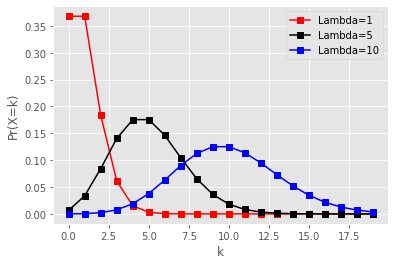

In [ ]:
p1 = poisson(1.)
p2 = poisson(5.)
p3 = poisson(10.)
x = [i for i in range(20)]

plt.figure()
plt.plot(x, p1.pmf(x), color='r', marker='s', label='Lambda=1')
plt.plot(x, p2.pmf(x), color='k', marker='s', label='Lambda=5')
plt.plot(x, p3.pmf(x), color='b', marker='s', label='Lambda=10')
plt.legend()
plt.xlabel('k')
plt.ylabel('Pr(X=k)')
plt.savefig(output_path + 'poisson.pdf')
